In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))

In [3]:
shp_path = "data/UKR_adm1.shp"
sf = shp.Reader(shp_path)

In [4]:
len(sf.shapes())

27

In [5]:
sf.records()[0]

Record #0: [240, 'UKR', 'Ukraine', 1, 'Cherkasy', 'UA.CK', 0, '', "Oblast'", 'Region', '', "Cherkas'ka Oblast'|Cherkasskaya Oblast'|Cherkassy"]

In [33]:
def plot_map(sf, figsize = (11,9)):
    plt.figure(figsize = figsize)

    for idx, shape in enumerate(sf.shapeRecords()):
        x = [i[0] for i in shape.shape.points]
        y = [i[1] for i in shape.shape.points]
        plt.plot(x, y)

        x0 = np.mean(x)
        y0 = np.mean(y)
        plt.text(x0 - 0.1 * len(shape.record['NAME_1']), y0, shape.record['NAME_1'], fontsize=10)


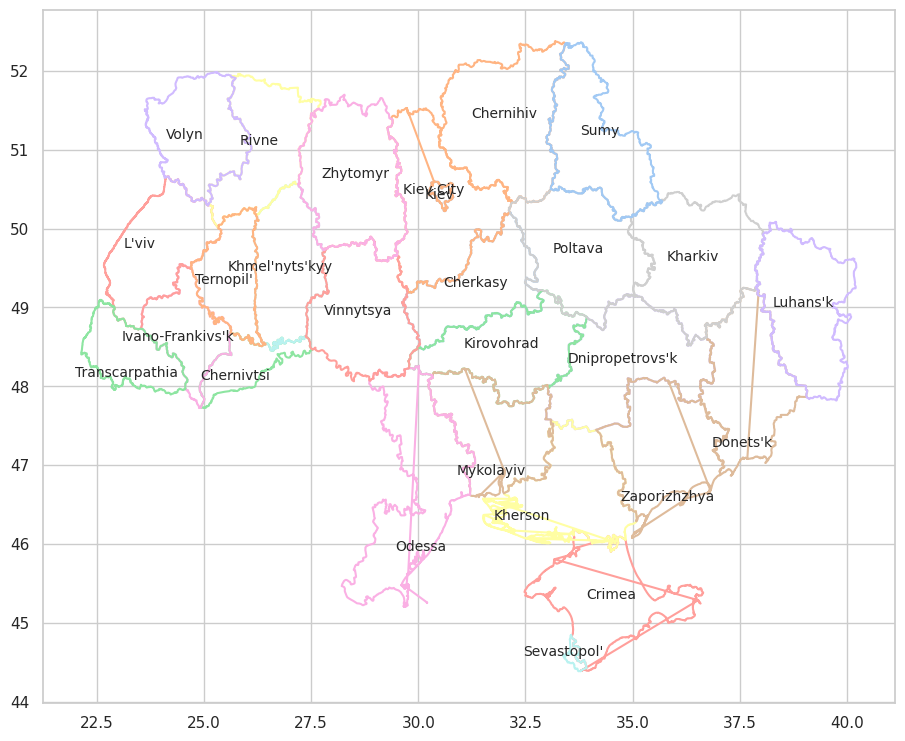

In [34]:
plot_map(sf)